# Exploratory Data Analysis of the Spotify Tracks Popularity Dataset

Dataset: https://www.kaggle.com/datasets/gauthamvijayaraj/spotify-tracks-dataset-updated-every-week

This notebook serves as a prerequisite for the modelling part of the project. In this file we want to explore the relationships between attributes as well as data distributions  
and uncover what kind of data we are dealing with. 

In [384]:
import os
import sys

sys.dont_write_bytecode = True

import requests
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from dotenv import load_dotenv

from sklearn.model_selection import train_test_split
from scipy.stats import shapiro

load_dotenv()
sns.set_theme()
warnings.filterwarnings('ignore')

import importlib
import etl
importlib.reload(etl)
from etl import *

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from math import sqrt

In [385]:
DATA_DIR = './Data/'
TRACK_FILE = 'spotify_tracks_kaggle_weekly.csv'
tracks = pd.read_csv(DATA_DIR + TRACK_FILE)


In [386]:
data = tracks.copy()

### Data separation

Splitting the data into train and test sets.\
All analyses will be performed on the training data.

We will be using the same random state and test size for all analyses.

In [387]:
RANDOM_STATE = 21
TEST_SIZE = 0.1

In [388]:
# define target and features
y = data['popularity']
X = data.drop('popularity', axis=1)

In [389]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [390]:
# Concatenate the training data
data = pd.concat([X_train, y_train], axis=1)

### Null analysis

- Look for missing values 
- Determine impact on the dataset


In [391]:
# first look
data.isnull().sum()

track_id            0
track_name          0
artist_name         0
year                0
artwork_url         0
album_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
track_url           0
language            0
popularity          0
dtype: int64

In [392]:
data.describe()

,year,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
count,56085.000000,56085.000000,56085.000000,5.608500e+04,56085.000000,56085.000000,56085.000000,56085.000000,56085.000000,56085.000000,56085.000000,56085.000000,56085.000000,56085.000000,56085.000000
mean,2014.441134,0.362395,0.596807,2.422366e+05,0.602422,0.146831,5.104235,0.194362,-64.217260,0.585825,0.087633,117.916643,3.856414,0.495443,15.347865
std,9.626506,0.314682,0.186053,1.103979e+05,0.246036,0.308334,3.552581,0.172198,2350.193108,0.493704,0.115071,28.489777,0.503690,0.264921,18.598037
min,1971.000000,-1.000000,-1.000000,5.000000e+03,-1.000000,-1.000000,-1.000000,-1.000000,-100000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2011.000000,0.067200,0.497000,1.921850e+05,0.439000,0.000000,2.000000,0.093300,-10.736000,0.000000,0.036700,95.925000,4.000000,0.292000,0.000000
50%,2017.000000,0.285000,0.631000,2.362120e+05,0.639000,0.000026,5.000000,0.125000,-7.510000,1.000000,0.048800,117.999000,4.000000,0.508000,7.000000
75%,2022.000000,0.633000,0.729000,2.859730e+05,0.803000,0.015500,8.000000,0.243000,-5.458000,1.000000,0.089100,135.059000,4.000000,0.710000,26.000000
max,2024.000000,0.996000,0.979000,4.581483e+06,1.000000,0.999000,11.000000,0.998000,1.233000,1.000000,0.959000,239.970000,5.000000,0.995000,93.000000


No missing values found at first, but looking at descriptive statistics, we find that they are represented by the value -1.

We know this, because for most of these columns, the dataset states the range of the values being 0-100, or 0.0-1.0.

In [393]:
# count columns with -1 as null
print("Data shape =", data.shape)
data.apply(lambda x: x == -1).sum()

Data shape = (56085, 22)


track_id             0
track_name           0
artist_name          0
year                 0
artwork_url          0
album_name           0
acousticness        31
danceability        31
duration_ms          0
energy              31
instrumentalness    31
key                 31
liveness            31
loudness             0
mode                31
speechiness         31
tempo               31
time_signature      31
valence             31
track_url            0
language             0
popularity           0
dtype: int64

The number of 'null' values is the same for all columns, suggesting that the same rows have missing values for all columns. 

The number is negligable compared to the size of the dataset, so for this analysis we will drop them.

In [394]:
# select given columns
null_columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'key',
                'liveness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

# drop columns with only -1
data.replace(-1, np.nan, inplace=True)
data = data.dropna(subset=null_columns)

### Distribution analysis

In [395]:
# split data into numeric and categorical
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])
print(numeric_data.shape, categorical_data.shape)

(56054, 15) (56054, 7)


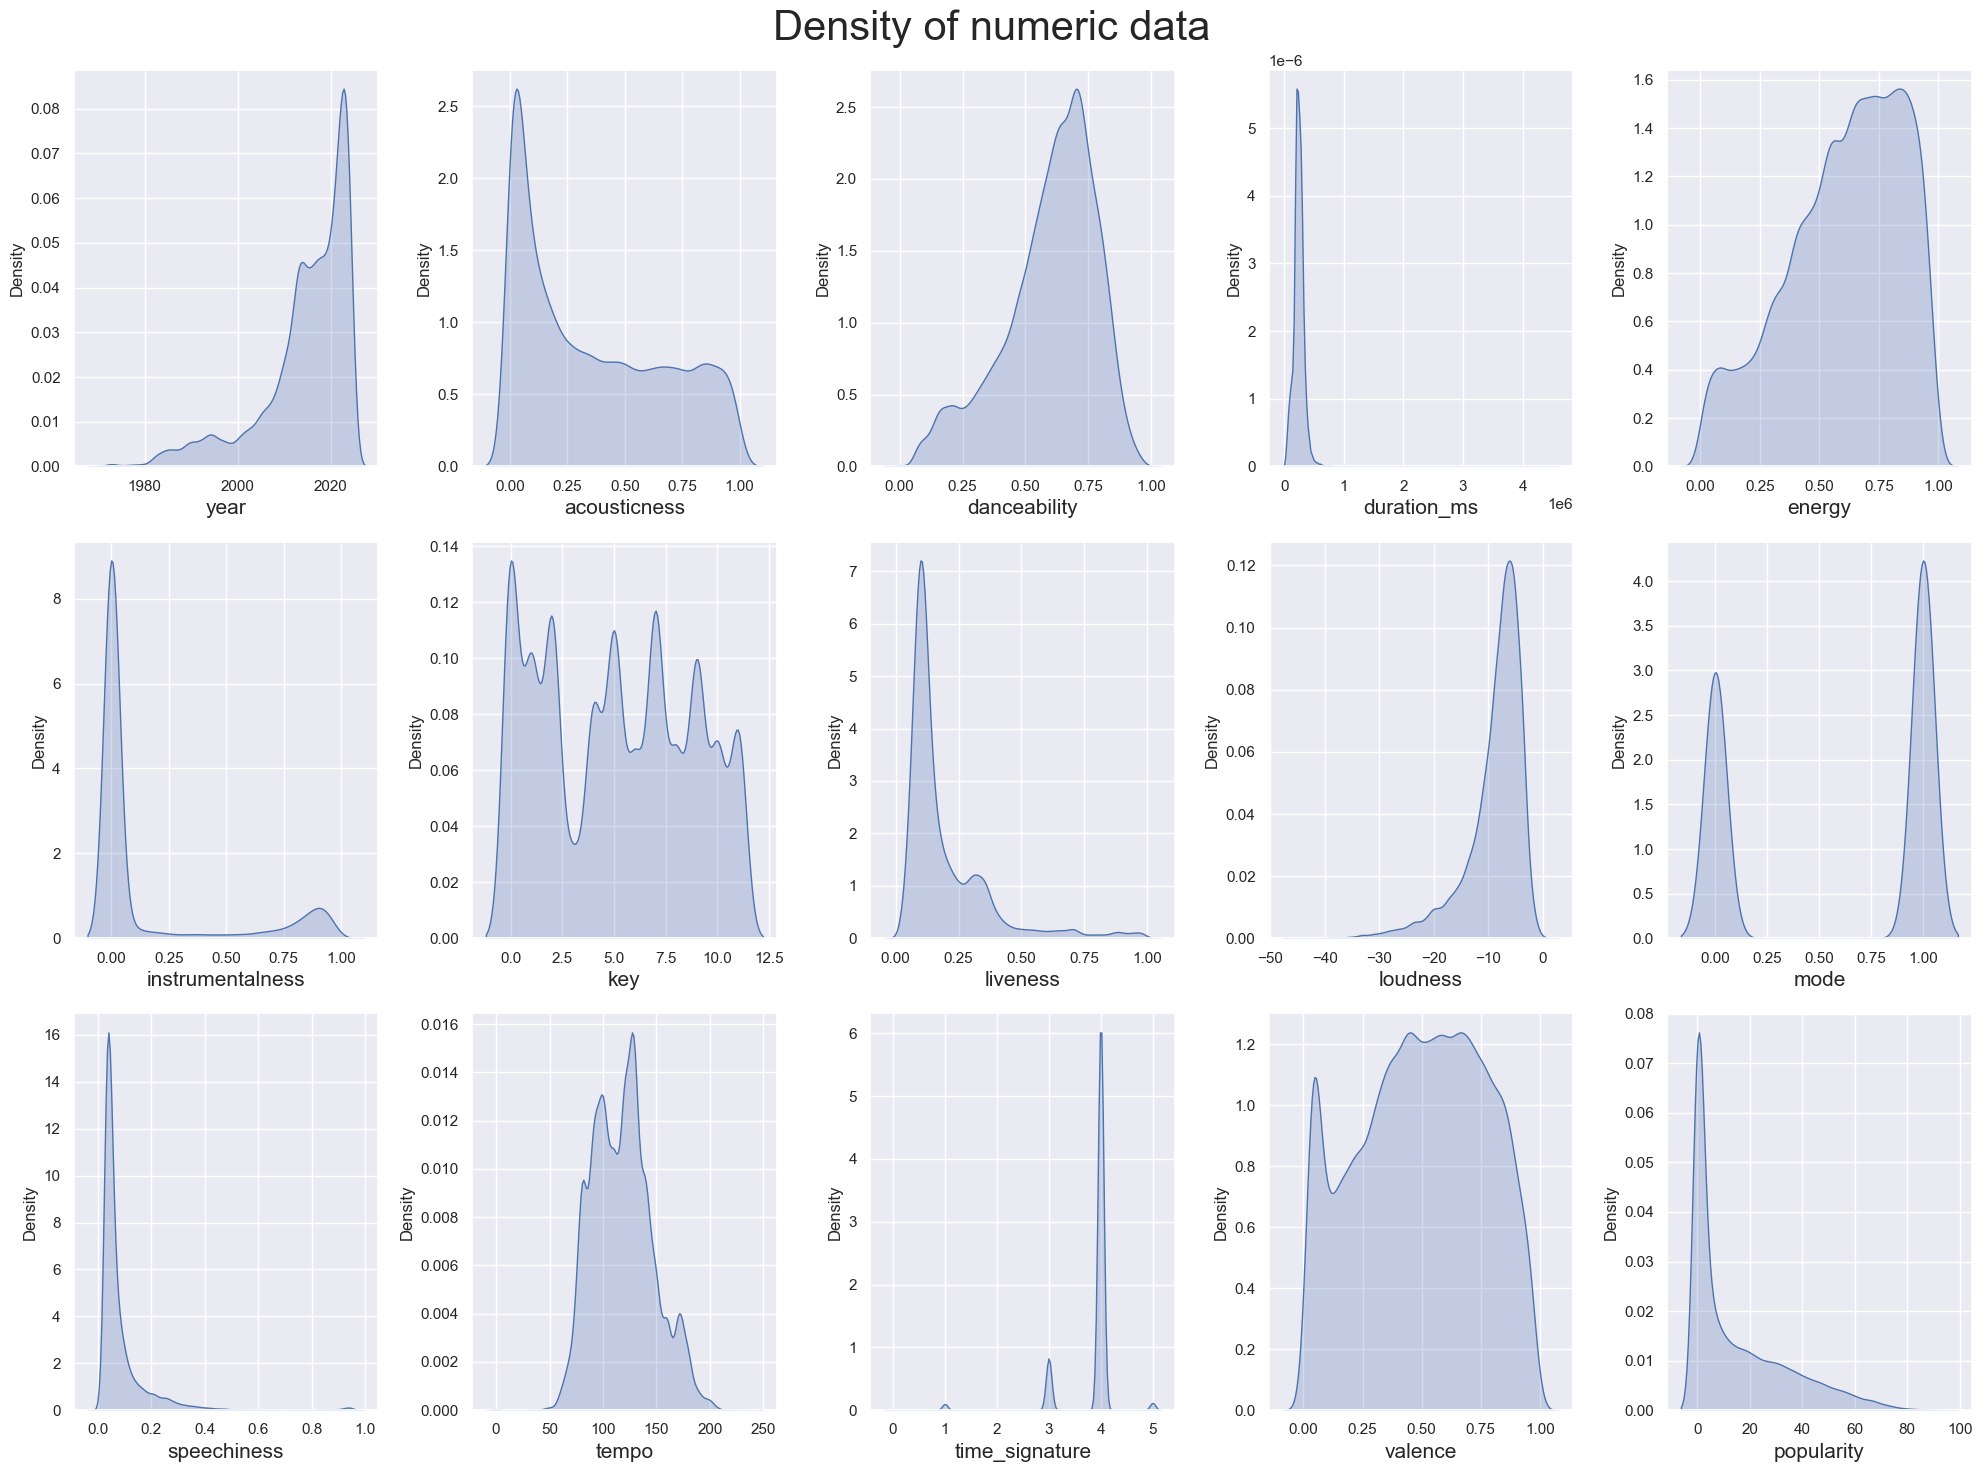

In [396]:
# Plot density of numeric data
fig, axes = plt.subplots(3, 5, figsize=(20, 15))
for i, col in enumerate(numeric_data.columns):
    sns.kdeplot(numeric_data[col], ax=axes[i // 5, i % 5], fill=True)
    axes[i // 5, i % 5].set_xlabel(col, fontsize=15)
fig.suptitle('Density of numeric data', fontsize=30)
plt.tight_layout()

After inspection, we can tell that some of the numeric attributes ['key', 'mode', 'time_signature'] are categorical. From the data that we marked categorical, only language seems to be relevant.

In [397]:
categorical_data = pd.concat([categorical_data, data[['key', 'mode', 'time_signature']]], axis=1)
categorical_data = categorical_data.drop(['track_id', 'track_name','artist_name', 'artwork_url', 'album_name', 'track_url'], axis=1).reset_index(drop=True)

numeric_data = numeric_data.drop(['key', 'mode', 'time_signature'], axis=1).reset_index(drop=True)

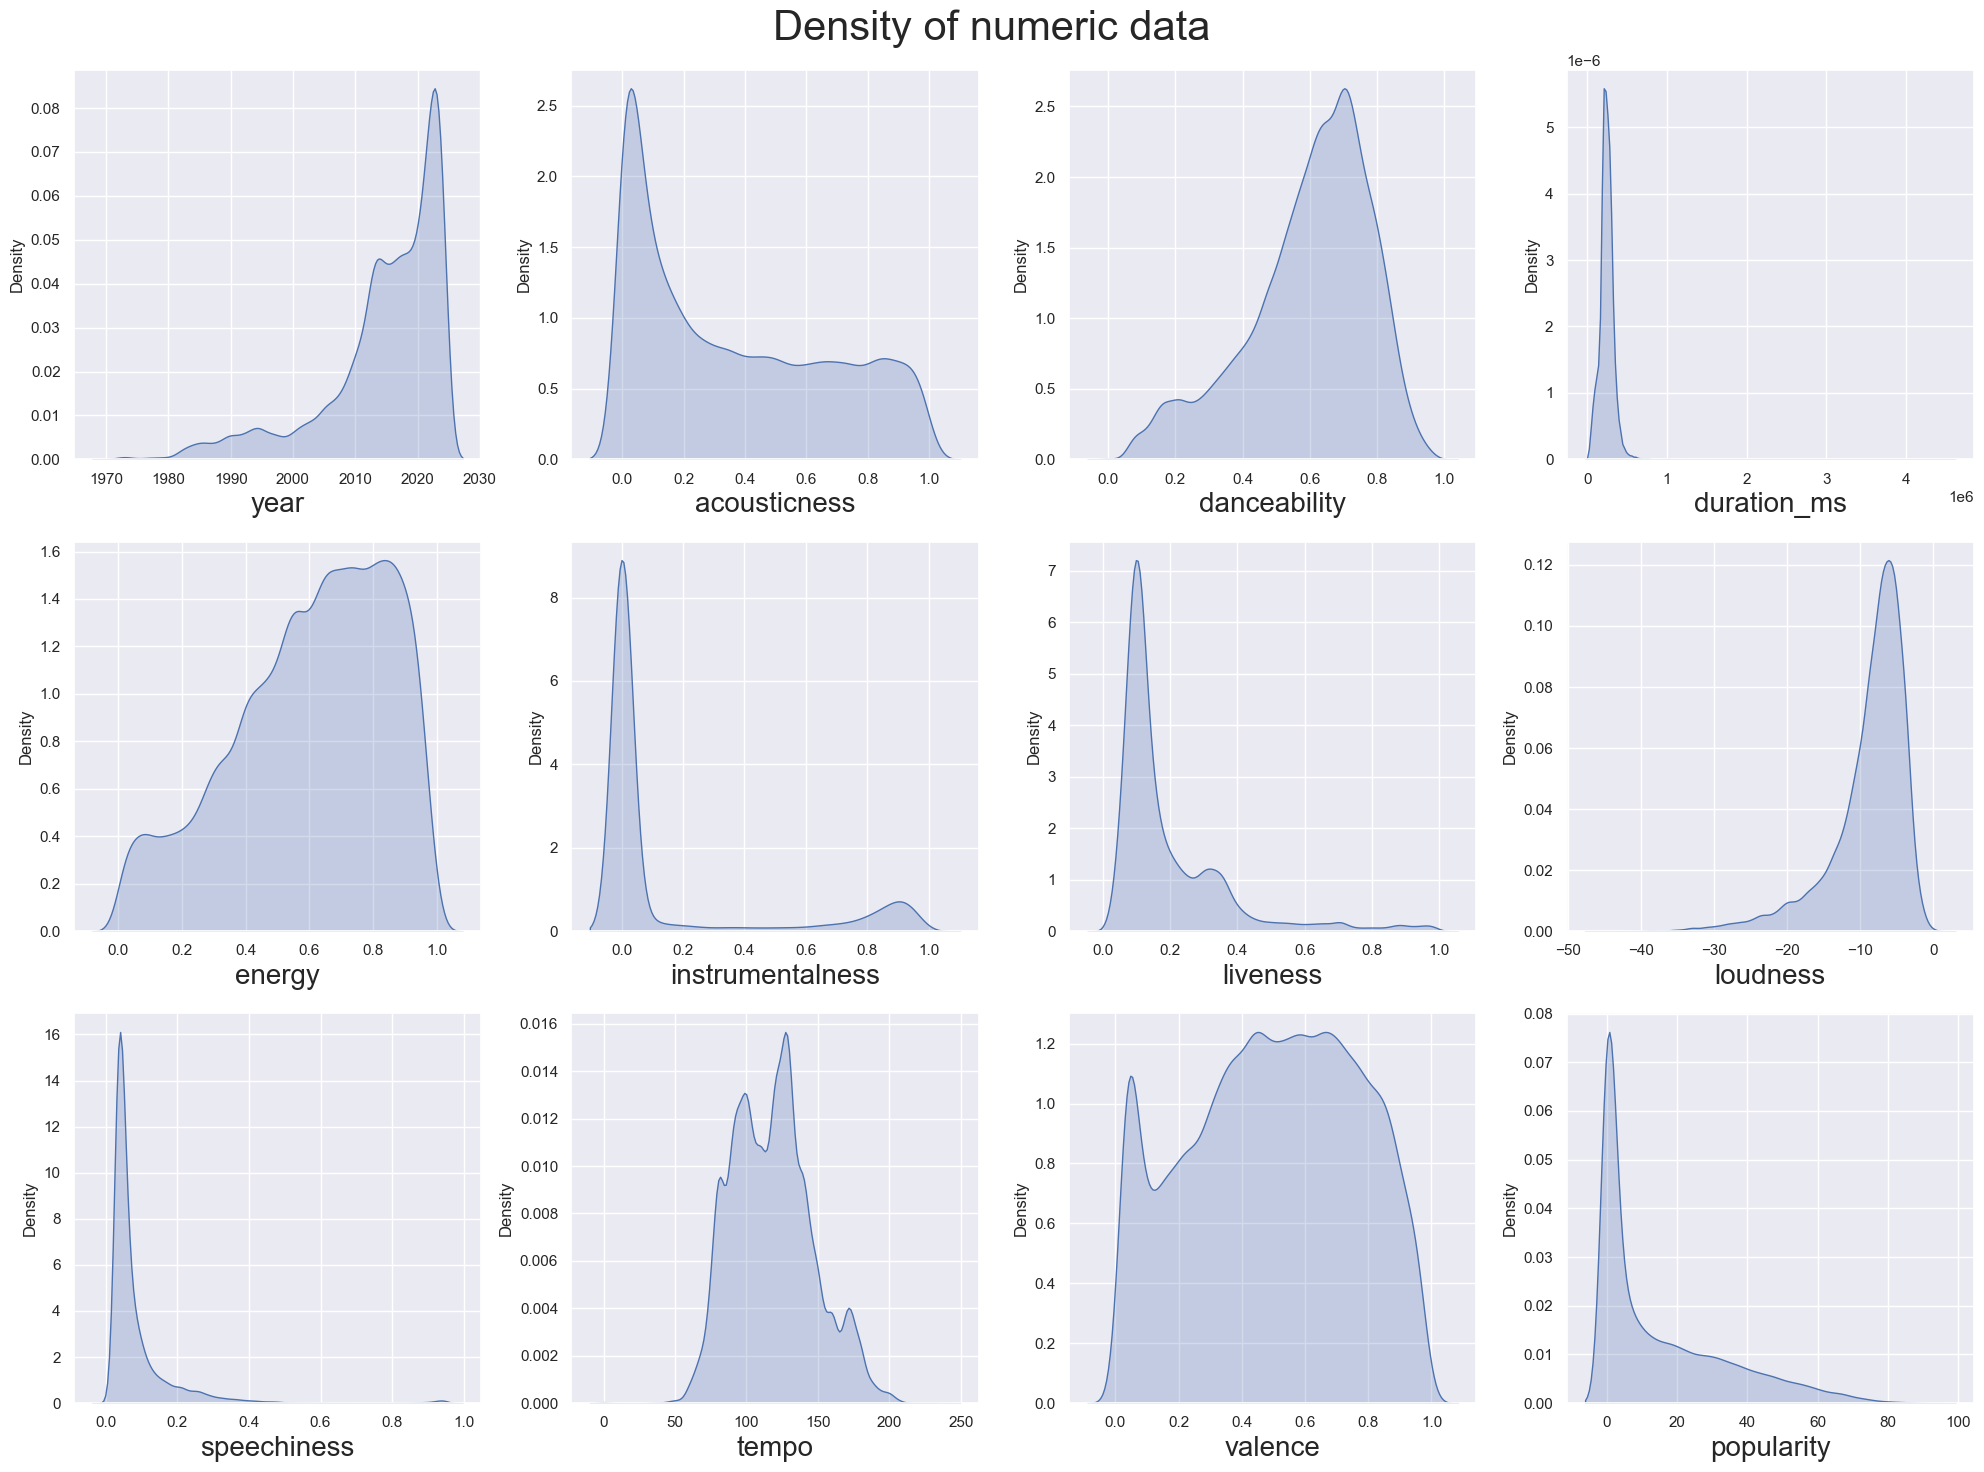

In [398]:
# Plot density of numeric data
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
for i, col in enumerate(numeric_data.columns):
    ax = axes[i // 4, i % 4]
    ax.set_xlabel(col, fontsize=20)
    sns.kdeplot(data[col], ax=ax, fill=True)
fig.suptitle('Density of numeric data', fontsize=30)
plt.tight_layout()
plt.show()

#### Popularity across song release date - averaging aggregation

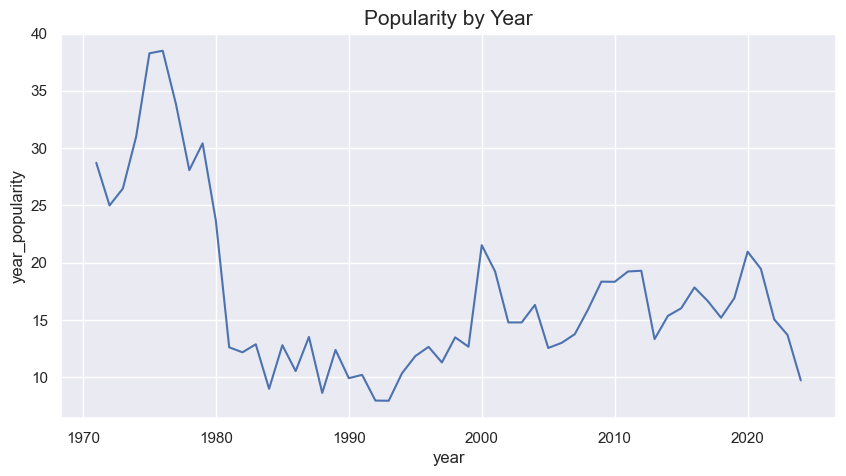

In [399]:
popularity_by_year = data.groupby('year').agg(
    year_popularity = ('popularity', 'mean')
)

popularity_by_year = popularity_by_year.reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=popularity_by_year, x='year', y='year_popularity')
plt.title('Popularity by Year', fontsize=15)
plt.show()

We will investigate the count bias -> We compare the counts of songs in a given year to the mean popularity value to see if the popularity is biased by the number of songs released in a given year.

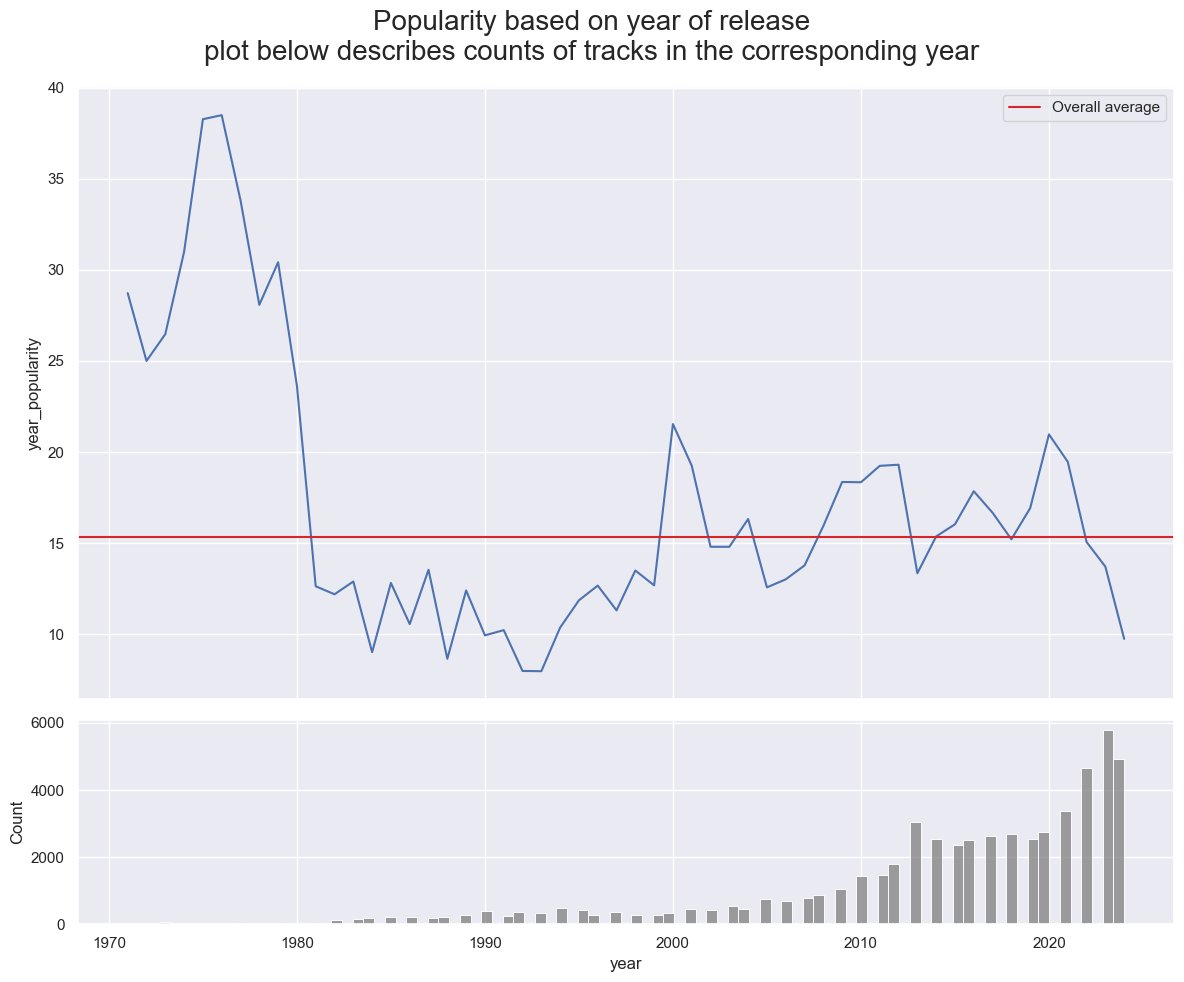

In [400]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

sns.lineplot(data=popularity_by_year, x='year', y='year_popularity', ax=ax[0])
sns.histplot(data=numeric_data, x='year', color='grey')

ax[0].axhline(y=data['popularity'].mean(), color='tab:red', label='Overall average')

ax[0].legend()

fig.suptitle('Popularity based on year of release\nplot below describes counts of tracks in the corresponding year', fontsize=20)
plt.tight_layout()
plt.show()

There could be bias due to the very strong imbalance of counts against the aggregated values.

#### Outliers in numeric values

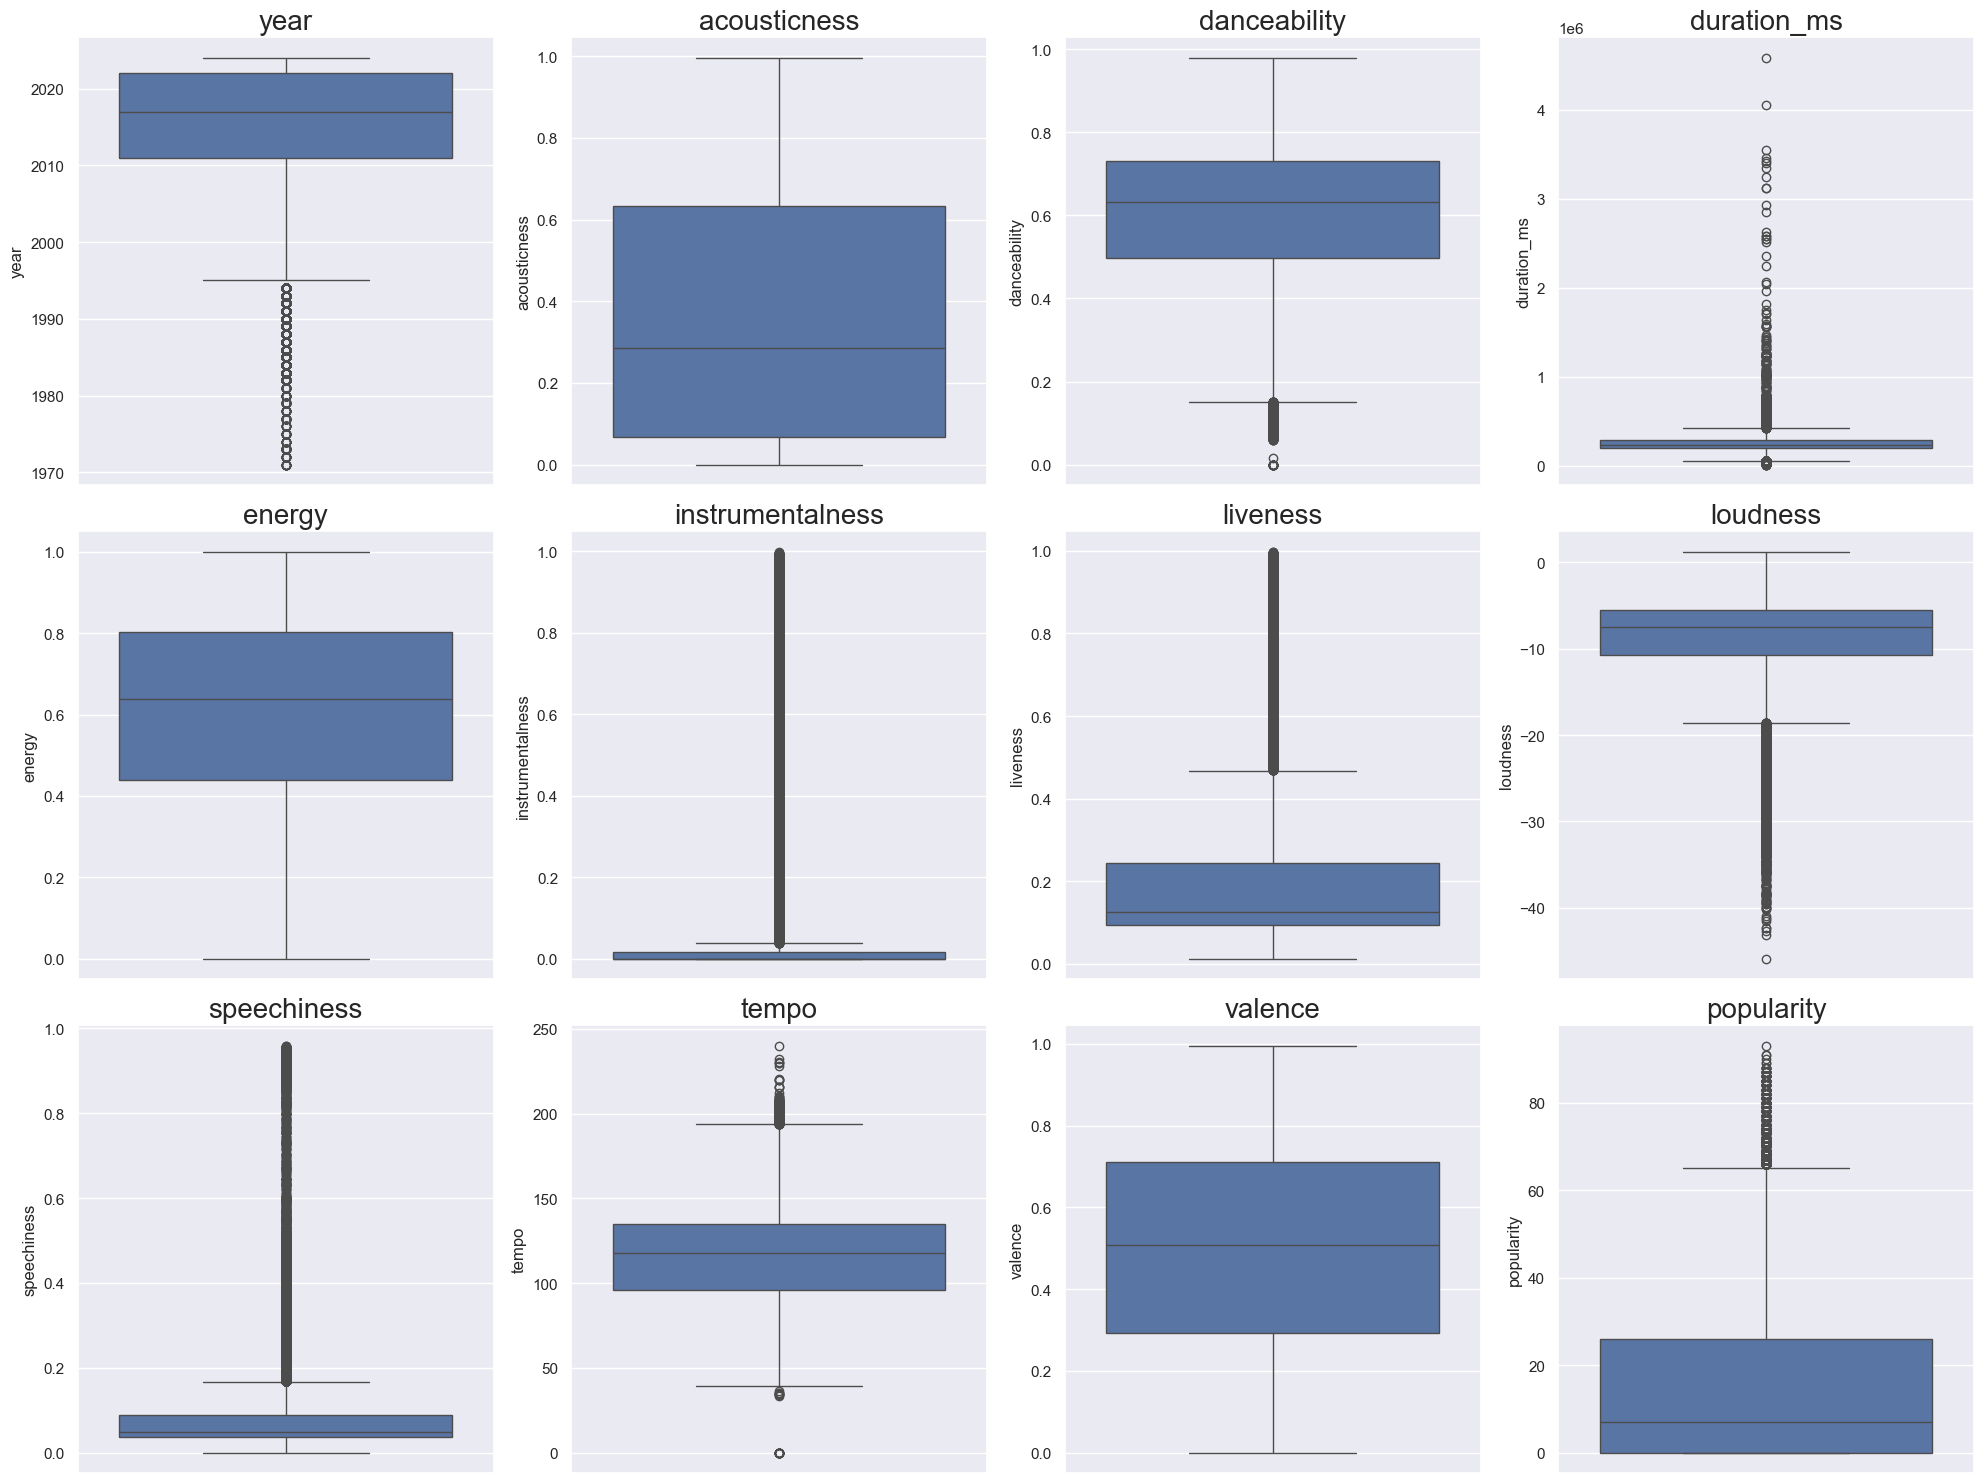

In [401]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
ax = axes.flatten()
for i, col in enumerate(numeric_data.columns):
    sns.boxplot(data=numeric_data[col], ax=ax[i])  
    ax[i].set_title(col, fontsize=20)
plt.tight_layout()
plt.show()

It is apparent that outliers are present. 

Attributes with the most visible outlier values are: 

- year
- duration_ms
- instrumentalness
- liveness
- loudness
- speechiness
- popularity

What is notable here is that the mean of popularity is very close to zero, which makes sense since usually only a small fraction of songs break through and become popular in real life.

We will investigate the densities of these attributes and see how the outliers change the shape of their distribution.

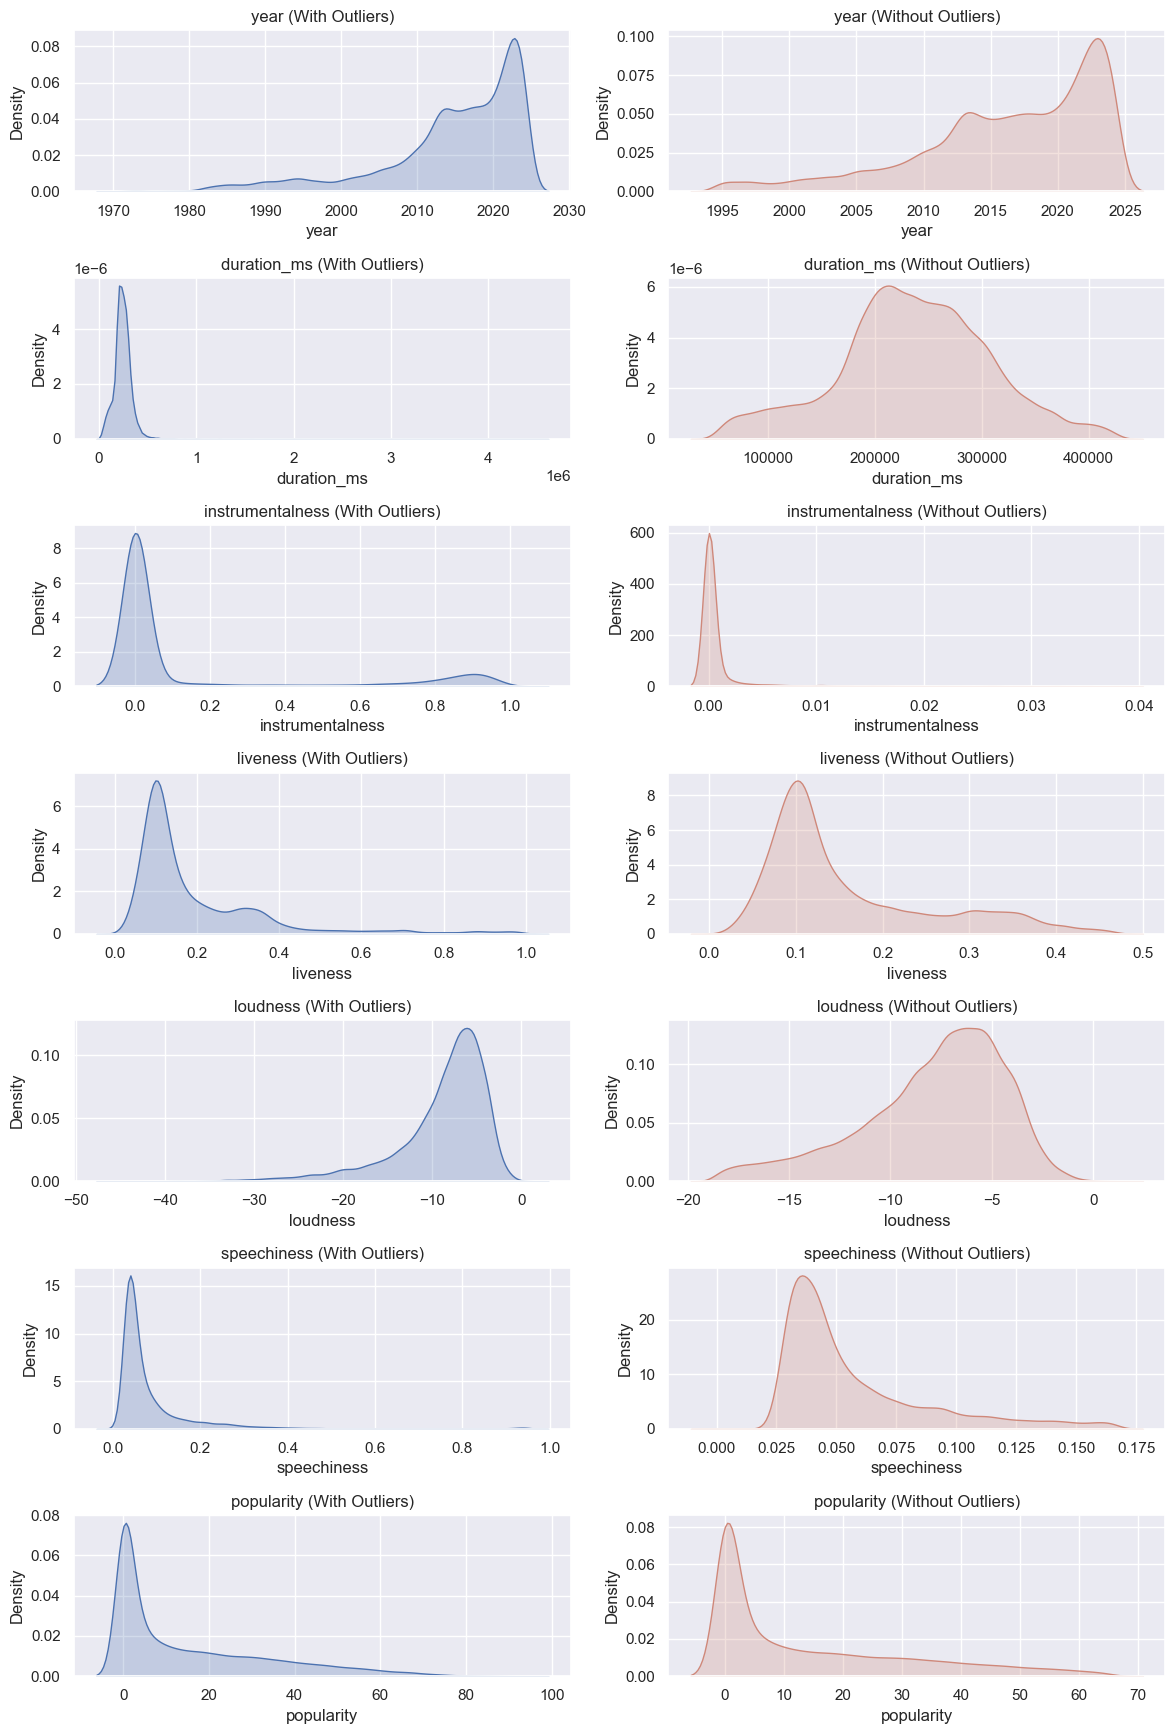

In [402]:
# outlier heavy columns
cols = ['year', 'duration_ms', 'instrumentalness', 'liveness', 
        'loudness', 'speechiness', 'popularity']


# calculate outlier thresholds
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# print(lower_bound)
# print(upper_bound)

outlierless_data = numeric_data[
    numeric_data.apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name]))
]

num_cols = len(cols)
fig, axes = plt.subplots(nrows=num_cols, ncols=2, figsize=(12, num_cols * 2.5))
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(cols):  #plot the distributions before and after dropping outliers
    sns.kdeplot(numeric_data[col].dropna(), ax=axes[i, 0], fill=True)
    axes[i, 0].set_title(f"{col} (With Outliers)")
    
    sns.kdeplot(outlierless_data[col].dropna(), ax=axes[i, 1], fill=True, color='#cf887a')
    axes[i, 1].set_title(f"{col} (Without Outliers)")

plt.tight_layout()
plt.show()

Number of outliers in each attribute:

In [403]:
print(outlierless_data.isna().sum())

year                 3647
acousticness            0
danceability         1181
duration_ms          2043
energy                  0
instrumentalness    12790
liveness             3779
loudness             3612
speechiness          6575
tempo                 341
valence                 0
popularity            987
dtype: int64


We can see that the largerst amount of outliers are present in the instrumentalness attribute, where it seems most values are very close to 0 and the rest is around 0.9.

Overall there is a lot of outliers in the dataset and for most of the attributes dropping these values is not possible, so when modelling we should consider a robustscaler or similar scaling methods which find ways to handle this correctly.

### Categorical attributes

After numeric columns, we take a look at categorical attributes:

In [404]:
categorical_data

,language,key,mode,time_signature
0,English,2.0,0.0,4.0
1,Korean,10.0,1.0,4.0
2,English,6.0,1.0,4.0
3,English,0.0,0.0,4.0
4,Tamil,8.0,1.0,4.0
...,...,...,...,...
56049,Unknown,1.0,1.0,1.0
56050,Hindi,1.0,0.0,4.0
56051,Unknown,10.0,1.0,4.0
56052,Tamil,7.0,0.0,4.0


#### Language

Although not uniform, language distribution is roughly balanced with english not having an overwhelming majority.

Text(0.5, 1.0, 'Language Distribution')

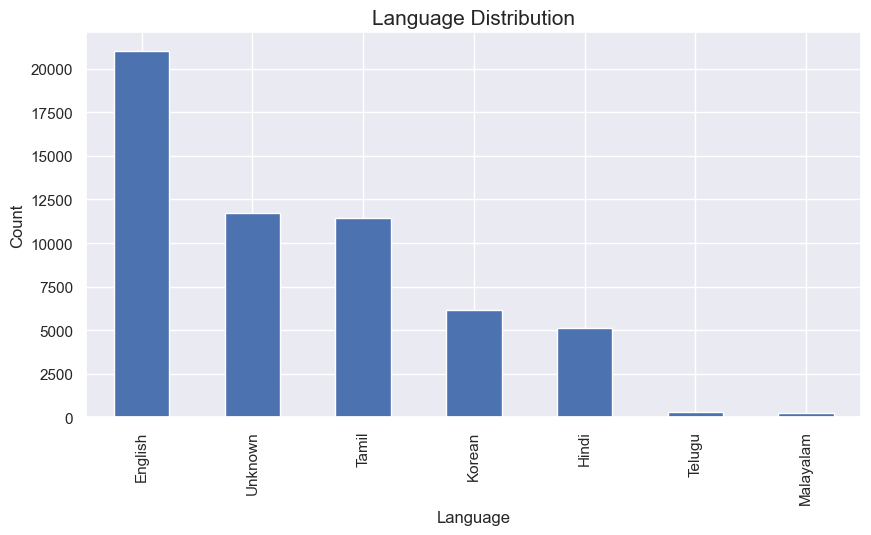

In [405]:

xlabel = 'Language'
ylabel = 'Count'
title = 'Language Distribution'
plt.figure(figsize=(10, 5))
data['language'].value_counts().plot(kind='bar')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title, fontsize=15)

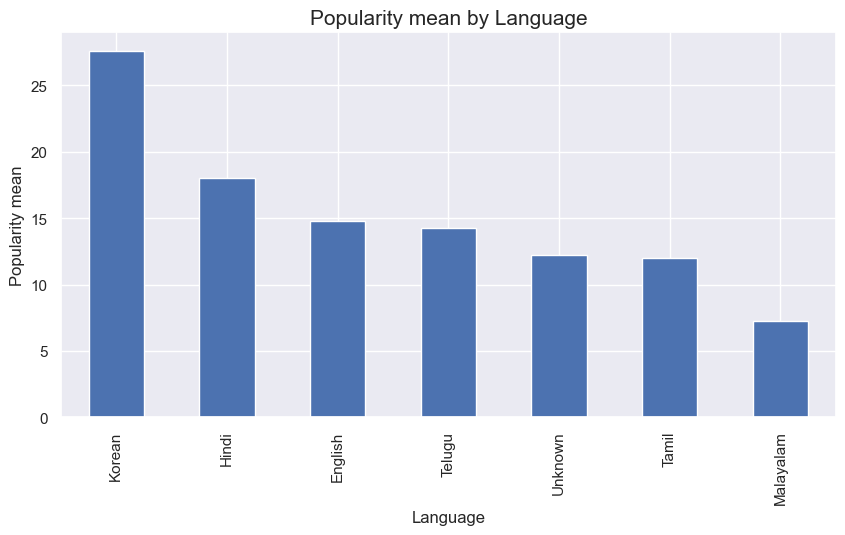

In [406]:
language_popularity = data.groupby('language').agg(
    popularity_mean = ('popularity', 'mean')
)

language_popularity = language_popularity.reset_index().sort_values(by='popularity_mean', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
language_popularity.plot(kind='bar', x='language', y='popularity_mean', ax=ax)
plt.title('Popularity mean by Language', fontsize=15)
plt.xlabel('Language')
plt.ylabel('Popularity mean')
plt.legend().remove()
plt.show()

Figure above shows that the highest mean popularity rating of songs are the ones with korean as the detected language, followed by the remaining languages with a roughly uniform distribution.

#### Key and mode

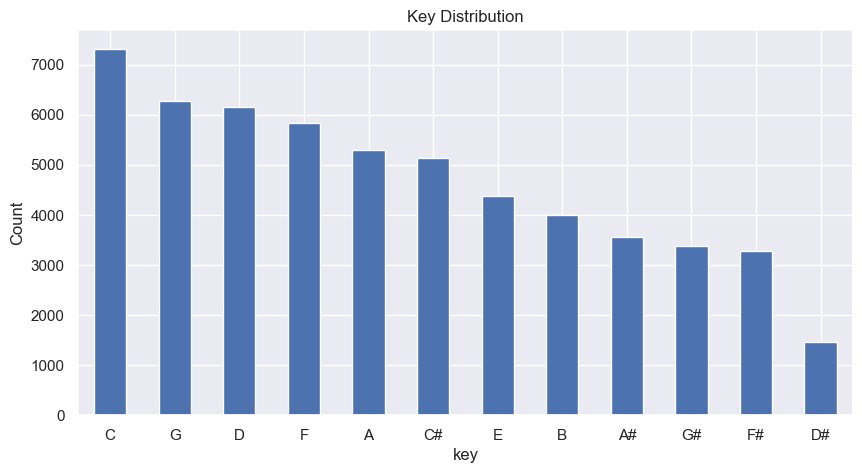

In [407]:
copy_data = categorical_data.copy()

keys = {
    0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F', 
    6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'
}

copy_data['key'] = copy_data['key'].replace(keys)

copy_data.sort_values('key', inplace=True)
fig, ax = plt.subplots(figsize=(10, 5))
copy_data['key'].value_counts().plot(kind='bar', ax=ax)
plt.title('Key Distribution')
plt.ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.grid(True)
plt.show()

Mode in itself will not tell us much, so we will combine it with a key to create an actual 'key' of the song as it is called in music theory. 

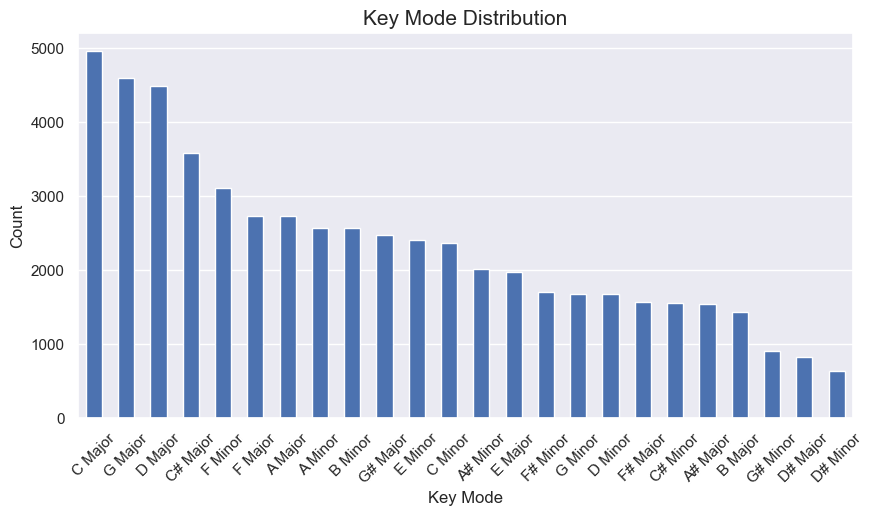

In [408]:
# combine key and mode column
copy_data['mode'] = copy_data['mode'].replace(0, 'Minor')
copy_data['mode'] = copy_data['mode'].replace(1, 'Major')

copy_data['key_mode'] = copy_data['key'] + ' ' + copy_data['mode']

fig, ax = plt.subplots(figsize=(10, 5))
copy_data['key_mode'].value_counts().plot(kind='bar', ax=ax)
plt.title('Key Mode Distribution', fontsize=15)
plt.ylabel('Count')
plt.xlabel('Key Mode')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.grid(axis='x')
plt.show()

So the most prevalent keys are C, G and D major. These are usually associated with happy soundinng melodies and similar. Another relevant attribute to look at might be attributes like valence or energy.

Next we will look which key and mode has the highest mean popularity.

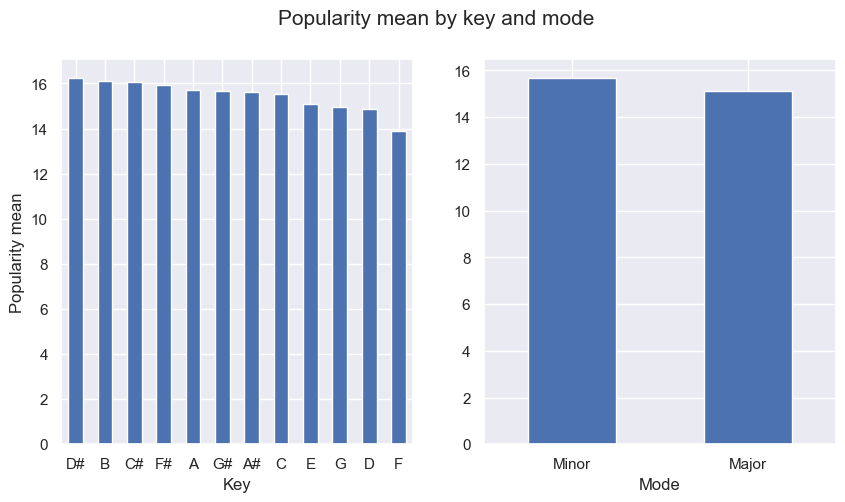

In [409]:
copy_data['popularity'] = numeric_data['popularity']

key_popularity = copy_data.groupby('key').agg(
    popularity_mean = ('popularity', 'mean')
)
key_popularity = key_popularity.reset_index().sort_values(by='popularity_mean', ascending=False)

mode_popularity = copy_data.groupby('mode').agg(
    popularity_mean = ('popularity', 'mean')
)
mode_popularity = mode_popularity.reset_index().sort_values(by='popularity_mean', ascending=False)


fig, ax = plt.subplots(1,2,figsize=(10, 5))
key_popularity.plot(kind='bar', x='key', y='popularity_mean', ax=ax[0])
mode_popularity.plot(kind='bar', x='mode', y='popularity_mean', ax=ax[1])
fig.suptitle('Popularity mean by key and mode', fontsize=15)
ax[0].set_xlabel('Key')
ax[0].set_ylabel('Popularity mean')
ax[1].set_xlabel('Mode')
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=0)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=0)

ax[0].legend().remove()
ax[1].legend().remove()
plt.show()

Popularity is evenly distributed throughout both key and mode, suggesting these columns will not have a big effect on popularity.

#### Time signature

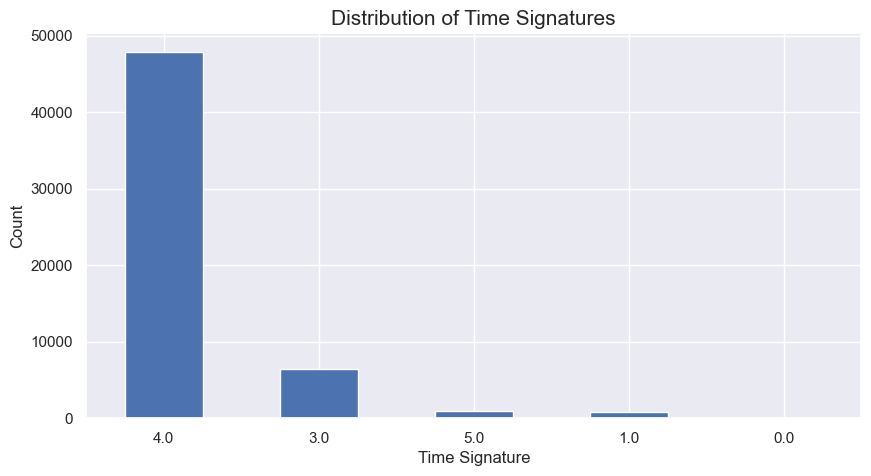

time_signature
4.0    47944
3.0     6404
5.0      911
1.0      775
0.0       20
Name: count, dtype: int64

In [410]:
fig, ax = plt.subplots(figsize=(10, 5))
categorical_data['time_signature'].value_counts().plot(kind='bar')
plt.xlabel('Time Signature')
plt.ylabel('Count')
plt.title('Distribution of Time Signatures', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()
data['time_signature'].value_counts()

The dataset described the column as ranging from 3/4 to 7/4, yet we also see values -1 (removed), 0 and 1. (we expected values from 3 - 7). 
We can see that the two most common time signatures are 4/4(standard) and 3/4(waltz) which was to be expected.

Since this audio feature is just estimated using some machine learning model and time signatures outside these two are not that common, 
the models dont really have the capacity to categorize them correctly, so there is also a possibility that a lot of 4/4 and 3/4 ts are misclassified.

The description of this attribute is not very clear and it is not very apparent what the values 0 and 1 represent.

In [411]:
# rows with time signature 0,-1,1
data[(data['time_signature'] == 0)].head()
# data[(data['time_signature'] == -1)].head()
# data[(data['time_signature'] == 1)].head()

,track_id,track_name,artist_name,year,artwork_url,album_name,acousticness,danceability,duration_ms,energy,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_url,language,popularity
57225,4XwGrhiOTz0FapbeOdtCpN,Mi Amor,Daniel Pemberton,2018,https://i.scdn.co/image/ab67616d0000b27354a3ee...,Spider-Man: Into the Spider-Verse (Original Sc...,0.963,0.0,79553.0,0.047100,...,0.144,-27.968,0.0,0.0,0.0,0.0,0.0,https://open.spotify.com/track/4XwGrhiOTz0Fapb...,English,52
1999,3M9tX5hIki8RaTGAkCx84O,Unga Phone Number Spelling Yenna??,Hiphop Tamizha,2018,https://i.scdn.co/image/ab67616d0000b273f13c09...,Meesaya Murukku (Original Background Score),0.792,0.0,14743.0,0.517000,...,0.178,-5.661,1.0,0.0,0.0,0.0,0.0,https://open.spotify.com/track/3M9tX5hIki8RaTG...,Tamil,0
44714,44s1d02BsSRyTakLgJHORT,Indians - Film Version,Alan Silvestri,1990,https://i.scdn.co/image/ab67616d0000b273e3484a...,Back To The Future Part III: 25th Anniversary ...,0.772,0.0,71160.0,0.387000,...,0.134,-10.568,1.0,0.0,0.0,0.0,0.0,https://open.spotify.com/track/44s1d02BsSRyTak...,English,11
36406,3BBHR7T7mYDviqZL0S5YW1,"Aaranadyam Kandathennu (From ""Love Land"")","Vijay Yesudas, Rimi Tomy",2020,https://i.scdn.co/image/ab67616d0000b273f5a8be...,Vijay Yesudas Birthday Special,0.138,0.0,259707.0,0.000184,...,0.407,-8.266,1.0,0.0,0.0,0.0,0.0,https://open.spotify.com/track/3BBHR7T7mYDviqZ...,Unknown,4
57224,1N99PdOEPHPJYGfsvI0jtf,Interlude IV: Train Tracks,Daniel Pemberton,2019,https://i.scdn.co/image/ab67616d0000b273849699...,Yesterday (Original Motion Picture Soundtrack),0.569,0.0,14013.0,0.593000,...,0.205,-19.750,1.0,0.0,0.0,0.0,0.0,https://open.spotify.com/track/1N99PdOEPHPJYGf...,English,0


Entries with time_signature 0, -1 or 1 have either extremely low popularity and other scores or completely invalid values (negative values for acousticness, danceability etc), some entries that might be considered either dropping or ignoring 

### Correlation analysis

##### Correlation matrix

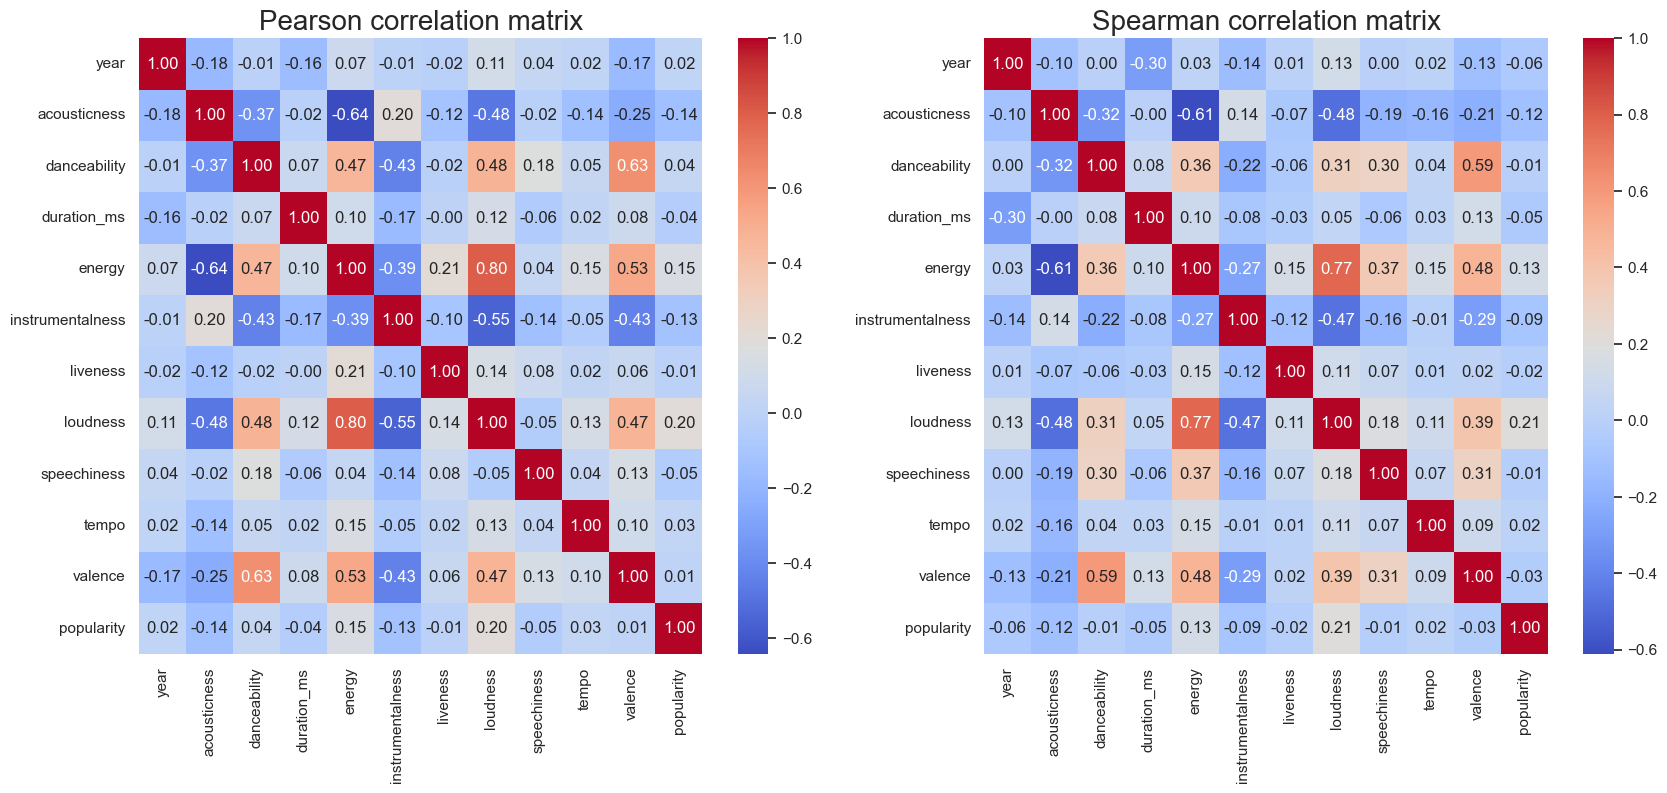

In [412]:
num_copy_data = numeric_data.copy()
pearson = num_copy_data.corr(method='pearson')
spearman = num_copy_data.corr(method='spearman')

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].set_title('Pearson correlation matrix', fontsize = 20)
axs[1].set_title('Spearman correlation matrix', fontsize = 20)
sns.heatmap(pearson, annot=True, fmt='.2f', cmap='coolwarm', ax=axs[0])
sns.heatmap(spearman, annot=True, fmt='.2f', cmap='coolwarm', ax=axs[1])
plt.show()


In [413]:
corr = num_copy_data.corr()['popularity'].sort_values(ascending=False)

corr

popularity          1.000000
loudness            0.202277
energy              0.149057
danceability        0.042019
tempo               0.027032
year                0.016648
valence             0.009365
liveness           -0.012182
duration_ms        -0.040907
speechiness        -0.052685
instrumentalness   -0.125927
acousticness       -0.139432
Name: popularity, dtype: float64

*contrary to previous assumption, despite the three major keys c,g,d being the most popular (which are usually associated with happy mood) here, valence has the smallest correlation with popularity of a track(valence describes musical positivity of the track)*

Relevant correlations to popularity:

positive:
- loudness (0.20)
- energy (0.15)

negative:
- acousticness (-0.14)
- instrumentalness (-0.13)
- speechiness (-0.05)

### Normality testing

Shapiro-Wilk normality tests -> we will use p-value treshold = 5%

In [414]:
p_value_treshold = 0.05

In [415]:
for col in numeric_data:
    
    column = numeric_data[col]

    _, p_value = shapiro(column)

    if p_value < p_value_treshold:
        print(f"Rejects hypothesis H0 for column {col:<20} with p-value = {p_value:.3f} ---> NO NORMAL DISTRIBUTION")

Rejects hypothesis H0 for column year                 with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column acousticness         with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column danceability         with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column duration_ms          with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column energy               with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column instrumentalness     with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column liveness             with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column loudness             with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column speechiness          with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column tempo                with p-value = 0.00

The testing suggests that the data will need transformations in order to be properly used by models.

## Additional attributes
Using spotify api we managed to get additional columns which could help with modelling.


In [416]:
DATA_DIR = './Data/'
TRACK_FILE = 'spotify_tracks_kaggle_weekly.csv'
ARTIST_FILE = 'spotify_tracks_artist_details.csv'

data_tracks = pd.read_csv(DATA_DIR + TRACK_FILE)
data_artist = pd.read_csv(DATA_DIR + ARTIST_FILE)
data = pd.merge(data_tracks, data_artist, on='track_id', how='left')

RANDOM_STATE = 21
TEST_SIZE = 0.1

X = data.drop('popularity', axis=1)
y = data['popularity']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

Drop irrelevant columns:

In [417]:
drop_columns = ['track_id', 'artwork_url', 'track_url', 'track_name']

X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

Inspect the new columns:

In [418]:
new_X_train = X_train.loc[:, 'track_name_y':]
new_X_train.drop(['track_name_y', 'artist_ids', 'artist_names'], axis=1, inplace=True)

new_X_train.head()

,artist_count,artist_popularities,artist_genres,artist_followers,avg_artist_popularity
60324,4.0,"0,0,0,0",|||,"114,3,0,4",0.0
24562,1.0,87,"k-pop,k-pop boy group,pop",77271082,87.0
55315,1.0,79,"boy band,dance pop,pop",2810285,79.0
42352,1.0,93,"canadian pop,pop",79774912,93.0
3914,4.0,"74,59,61,60","filmi|filmi,tamil pop|filmi,tamil pop|tollywood","9056936,88421,287588,69214",63.5


The main new relevant attributes are the **average popularity of the artists** on the given track and the **follower count** of the artists on the track. We will be using some transformations to make the new columns feasible for use in modelling.

<!-- transformation pipeline -->